In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()

%matplotlib inline

# ANN
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

# Set device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV & UMAP model
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/

In [3]:
# Load CSV
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

df.info()

# The performance set's size is defined in the SlidingWindowNFL-1 file. When kick_punt_umap_dim_1 (or 2) is blank
test_performance_df = df[df['kick_punt_umap_dim_1'].isna()]
df = df[df['kick_punt_umap_dim_1'].isna() == False]
print(f'df after perf set removed: {df.shape}')
print(f'performance set size: {test_performance_df.shape}')

# Remove missing odds data (Ignore data with no odds?)
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]

print(f'df after missing odds removed: {df.shape}')
print(f'df perf after missing odds removed: {test_performance_df.shape}')

# Load the UMAP
filename = "kick_punt_umap.sav"
umap_model = None
try:
    with open(filename, 'rb') as file:
        umap_model = pickle.load(file)
        print(type(umap_model))
except EOFError:
    print("The file is empty or corrupt. Please check its content.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5464 non-null   int64  
 1   Season                   5464 non-null   int64  
 2   Date                     5464 non-null   object 
 3   Home_Team                5464 non-null   object 
 4   Visitor_Team             5464 non-null   object 
 5   H_halftime_odds          5464 non-null   float64
 6   V_halftime_odds          5464 non-null   float64
 7   H_start_odds             5464 non-null   float64
 8   V_start_odds             5464 non-null   float64
 9   H_Won                    5464 non-null   float64
 10  D_First_Downs            5464 non-null   float64
 11  D_Rush                   5464 non-null   float64
 12  D_Yds                    5464 non-null   float64
 13  D_TDs                    5464 non-null   float64
 14  D_Cmp                   

### Remove items w/ missing odds data, apply UMAP to performance set

In [4]:
# Remove missing odds data
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]
print(test_performance_df.shape)

# ---- Apply UMAP to performance set ----
# Fit standardScaler on the training set
umap_columns = ["D_kick_punt_returns_lng", "D_kick_punt_returns_rt", "D_kick_punt_returns_yds"]
umap_train_df = df[umap_columns]
umap_scaler = StandardScaler().fit(umap_train_df)

# Scale the test set
scaled_return_game_df = umap_scaler.transform(test_performance_df[umap_columns])

if umap_model is None:
    print("UMAP not correctly loaded FIX NOW")

umap_embedding = umap_model.transform(scaled_return_game_df)
print(umap_embedding.shape)

# Create the two new columns, drop the 4
test_performance_df['kick_punt_umap_dim_1'] = umap_embedding[:,0]
test_performance_df['kick_punt_umap_dim_2'] = umap_embedding[:,1]

test_performance_df.drop(umap_columns, axis=1, inplace=True)
df.drop(umap_columns, axis=1, inplace=True)



(191, 70)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(191, 2)


In [5]:
test_performance_df[:5]
# print(test_performance_df['H_start_odds'][:5])
# print(test_performance_df['V_start_odds'][:5])

,Unnamed: 0,Season,Date,Home_Team,Visitor_Team,H_halftime_odds,V_halftime_odds,H_start_odds,V_start_odds,H_Won,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Cmp,D_Att,D_Yd,D_TD,D_INT,D_Sacked,D_Sacked_Yards,D_Net_Pass_Yards,D_Total_Yards,D_Fumbles,D_Lost,D_Turnovers,D_Penalties,D_Third_Down_Conv,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_passing_rushing_td,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_ff,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,D_tackles_solo,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_Final,D_Final_Allowed,D_start_odds,D_halftime_odds,D_datediff,D_pythagorean,kick_punt_umap_dim_1,kick_punt_umap_dim_2
5264,7449,2023,2024-01-21,KAN,BUF,2.386667,1.577778,2.073398,1.724771,1.0,-5.049,14.342,-4.790,-10.070,-1.931,-67.962,5.714,52.173,-0.224,3.239,1.041,-18.251,-53.359,-0.615,1.029,-0.423,-3.945,-13.555,27.766,-4.679,3.271,1.649,-0.306,0.766,0.376,-0.178,13.745,-10.854,-4.265,-0.947,-35.108,-1.125,-1.165,-0.193,-8.337,0.421,-0.257,0.277,25.928,0.859,-2.725,5.923,8.648,0.551,2.611,1.207,0.139,-1.272,-0.004,-5.790,-1.099,0.349,0.809,2.0,-0.073,-0.944908,9.706598
5265,7444,2023,2024-01-28,DET,SFO,1.263333,3.894444,4.307745,1.203585,0.0,-0.376,-5.287,1.664,-19.688,6.013,-10.797,3.569,26.740,-0.405,4.852,-0.741,15.220,-15.201,0.130,-0.277,-0.445,16.338,-14.753,38.606,-1.158,2.920,3.124,-0.397,-4.086,-0.315,-0.269,4.240,-1.072,-18.576,0.293,-30.421,0.024,-0.155,-0.104,0.189,0.511,-0.168,0.000,1.961,0.267,-2.540,-1.567,0.973,0.893,0.897,-0.082,0.198,-0.369,-0.064,-0.484,2.681,3.104,-2.631,-1.0,-0.178,4.765425,5.378789
5266,7445,2023,2024-01-28,KAN,BAL,1.345556,3.222222,2.885004,1.396731,1.0,-1.149,-29.932,-1.342,3.770,2.065,5.677,3.682,1.174,0.019,0.237,-6.887,15.044,-17.795,-0.440,0.002,0.246,1.906,-1.403,-7.241,0.512,7.909,4.222,0.376,-2.455,-0.990,-1.230,-16.767,-3.475,-19.850,-0.497,-32.839,-1.727,-0.833,-0.034,-13.352,-0.654,-0.109,0.207,14.747,0.109,-8.664,-8.438,0.226,-0.408,1.400,0.973,0.093,-1.516,-0.004,-8.754,-2.969,1.488,-1.877,-1.0,-0.126,0.746289,10.155971
5267,7645,2023,2024-02-11,SFO,KAN,1.301111,3.472222,1.757009,2.028809,0.0,1.930,23.153,3.614,-38.602,1.845,-27.846,2.388,45.530,0.263,-3.815,6.219,22.362,34.943,-0.535,-0.615,-0.271,-6.133,18.912,-20.599,2.204,-1.002,-0.423,0.194,6.831,0.779,0.370,3.113,1.567,2.206,0.951,12.581,1.320,1.064,0.080,13.771,-0.396,-0.668,-0.155,-14.084,-0.516,-2.174,-5.335,-3.160,0.132,-1.046,-1.315,-0.326,1.278,-0.052,3.839,3.252,-0.272,-2.171,0.0,0.104,6.982881,4.331357
5268,7808,2024,2024-10-10,SFO,SEA,1.056667,9.383333,1.461897,2.642566,1.0,-6.140,14.184,7.482,-32.831,-7.632,-101.676,-0.471,56.893,-1.129,-1.901,-3.625,-37.717,-7.982,1.507,0.691,-0.143,-21.287,6.148,1.838,0.993,-15.357,-12.401,-0.485,-3.408,-0.875,0.452,-3.691,10.496,-0.232,-1.471,29.735,-1.018,0.526,0.460,24.419,1.353,2.059,0.000,-0.919,0.618,-1.915,-3.603,-1.688,-1.445,-0.773,0.985,0.460,0.000,0.000,0.062,-6.312,-1.181,-8.327,0.0,0.026,-2.863090,8.433458


# Columns to use
(TODO)

## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [6]:
cat_cols = []

cont_cols = [col for col in nfl_utils.cont_cols if col not in nfl_utils.drop_cols]


y_col = ['H_Won'] # Old
y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']


# create cont_df and y_df from the df
print(df.shape)
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

# print(cont_df.dtypes)
print(cont_df.shape)
print(perf_y_df.shape)
print(perf_y_df.tail())
# print(perf_conts_df.tail())


(5264, 67)
(5264, 48)
(191, 5)
      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5459    0.0      1.724771      2.073398              0.0              0.0
5460    0.0      4.991514      1.159063              0.0              0.0
5461    1.0      4.513858      1.188369              0.0              0.0
5462    0.0      3.804017      1.250000              0.0              0.0
5463    0.0      1.790476      1.986097              0.0              0.0


In [7]:
print(perf_y_df[:5])
cont_df[:5]

      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5264    1.0      2.073398      1.724771         2.386667         1.577778
5265    0.0      4.307745      1.203585         1.263333         3.894444
5266    1.0      2.885004      1.396731         1.345556         3.222222
5267    0.0      1.757009      2.028809         1.301111         3.472222
5268    1.0      1.461897      2.642566         1.056667         9.383333


,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Cmp,D_Att,D_Yd,D_INT,D_Sacked,D_Sacked_Yards,D_Total_Yards,D_Fumbles,D_Lost,D_Turnovers,D_Penalties,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,D_tackles_solo,kick_punt_umap_dim_1,kick_punt_umap_dim_2,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_pythagorean,D_start_odds
0,2.265,5.140,-8.261,31.290,-8.121,43.430,4.074,-0.684,-0.044,-4.750,134.107,-0.342,-0.103,-1.526,22.515,35.846,-1.945,15.846,8.055,-1.257,34.941,-2.048,1.702,32.967,-6.551,24.316,-0.099,-11.221,0.180,0.276,10.643,-0.835,0.000,-4.599,0.526,0.0,0.0,0.0,5.291422,9.552850,0.599,-1.273,0.662,-0.094,2.044,0.441,0.114,1.181
1,-3.629,-29.721,-20.239,105.471,-4.695,135.596,-6.074,-0.011,-6.794,-1.007,-58.301,0.239,0.537,0.941,-2.555,13.787,-5.022,-2.121,1.048,1.272,19.176,1.702,0.835,7.434,-14.743,-19.537,-2.132,-82.452,-0.820,0.000,2.096,1.397,-0.165,-11.360,-1.272,0.0,0.0,0.0,7.618100,7.267665,-0.864,5.719,1.636,-0.153,-1.904,0.099,-0.063,1.330
2,2.647,-7.419,-4.353,41.000,3.283,62.070,-4.474,-0.184,-3.724,-4.224,65.592,-1.029,-0.110,-1.324,-13.379,13.787,-1.588,0.430,0.305,-0.460,2.772,-2.246,0.033,21.437,-3.029,10.765,-0.415,-4.886,-0.952,-0.165,-10.676,-0.140,-0.460,-21.176,-0.165,0.0,0.0,0.0,2.573103,1.891357,-0.989,-4.020,0.901,0.242,-1.007,-0.526,0.179,0.741
3,6.827,-3.625,2.011,-21.217,5.103,37.158,7.551,2.173,-2.059,-13.463,144.618,0.544,1.187,3.801,-11.202,49.173,5.379,14.000,10.915,3.441,21.096,-3.386,-0.460,47.860,-0.140,-5.044,1.118,-11.184,0.614,0.165,8.996,0.937,0.000,0.662,0.732,0.0,0.0,0.0,4.044179,8.739308,-4.794,-4.150,2.202,0.255,-0.390,-0.360,0.248,-5.646
4,3.110,-15.445,10.092,-12.125,-0.239,-82.890,1.221,0.368,-3.026,0.585,13.544,0.518,-0.544,-0.162,11.952,6.434,1.794,-8.794,-8.033,-0.360,-3.371,0.007,-1.228,-34.746,9.721,-6.382,0.754,40.412,-0.044,-0.276,-18.860,-1.121,0.276,1.985,-0.298,0.0,0.0,0.0,3.613956,2.804782,-1.349,-5.401,-0.890,0.103,-0.022,0.000,0.007,1.181


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [8]:
# min_max_scaler = preprocessing.MinMaxScaler()
# cont_scaled = min_max_scaler.fit_transform(cont_df.values)
# cont_df = pd.DataFrame(cont_scaled)
# cont_df.head()

# # test performance set
# perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
# perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [9]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

### 4. Convert conts to tensor

In [10]:
print(conts.shape)
print(y_col.shape)

(5264, 48)
(5264, 3)


In [11]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)


In [12]:
"""
Want: 
    An array > 1 elements for PCC formula
    A smaller array for kelly_criterion
    


x: 1d array of predictions between -1 and 1 where negative number means visitor predicted to win
y: ['H_Won', 'H_start_odds', 'V_start_odds']
pearson_multiplier: constant to multiply the pearson correlation coefficient's result by
max_bet_pct: max percentage allowed per bet.
return_res_array: Skip the torch.cumprod part
"""
def nfl_custom_criterion(x, y, pearson_multiplier=0.5, max_bet_pct=0.1, return_res_array=False):
    # ------------------------------------------------
    # Preliminary calculations
    # ------------------------------------------------
    acct_value = 100 # Preset account value
    h_start_odds = y[:,1]
    v_start_odds = y[:,2]
    h_won = y[:,0]
    y_decimal_odds = torch.where(x > 0, h_start_odds, v_start_odds) # Predicted vs actual odds (regardless of correct prediction)
    y_prob = 1 / y_decimal_odds                  # Probability (regardless of correct prediction)
    x_H_Won = torch.round(torch.sigmoid(20 * x)) # Sigmoid so that it's differentiable. The 20 is arbitrarily large number
    y_correct_prediction = torch.abs((x_H_Won - h_won))        # 1 if wrong bet, otherwise 0. Used to reset kelly when wrong
    y_correct_prediction_mult_two = 2 * y_correct_prediction   # 2 if wrong bet, 0 if correct
    x = torch.abs(x)

    
    # ------------------------------------------------
    # 1. Calculate the Pearson Correlation Coefficient
    # ------------------------------------------------
    n = x.size(0)
    sum_x = torch.sum(x)
    sum_x_squared = torch.sum(x**2)
    sum_y = torch.sum(y_prob)
    sum_y_squared = torch.sum(y_prob**2)
    sum_pow_x = torch.sum(x**2)
    sum_pow_y = torch.sum(y_prob**2)
    x_mul_y = torch.mul(x, y_prob)
    sum_x_mul_y = torch.sum(x_mul_y)

    
    # PCC Formula (eps to avoid NaN)
    eps = 1e-8
    pcc_numerator = n * sum_x_mul_y - sum_x * sum_y
    pcc_denominator_one = torch.sqrt(n * sum_pow_x - sum_x_squared + eps)
    pcc_denominator_two = torch.sqrt(n * sum_pow_y - sum_y_squared + eps)
    pcc = pcc_numerator / (pcc_denominator_one * pcc_denominator_two + eps)
    pcc = pearson_multiplier * torch.abs(pcc)

    
    # ------------------------------------------------
    # 2. Calculate the kelly criterion
    #    Entirely wrong predictions are negated and kept in "incorrect_bets" (pcc not applied to wrong predictions)
    #    Correct predictions are kept in "correct_bets". Pcc is applied to this & stored in pcc_adjusted_correct_bets
    #    Possible issue: This always bets max_bet_pct
    #    The result is cumulatively calculated. i.e. The sum of the previous values are used to calculate the next one
    # ------------------------------------------------
    kelly_criterion = x - ((1 - x) / y_decimal_odds)
    bet_multiplier = torch.clamp(kelly_criterion, min=0)   # Kelly results that are negative are ignored
    bet_multiplier = bet_multiplier*max_bet_pct            # Scale down the bets to the maximum allowed percentage per bet

    #correct_bets = bet_unadjusted_profit - (bet_unadjusted_profit * y_correct_prediction)   # All correct bets after kelly, profit or 0.
    #pcc_adjusted_correct_bets = correct_bets * (1 - pcc)                                    # "correct_bets" penalized by pcc
    #incorrect_bets = bet_unadjusted_profit - (bet_unadjusted_profit * y_correct_prediction_mult_two) # Negative numbers are incorrect bets
    #incorrect_bets = torch.clamp(incorrect_bets, max=0)  # Restrict to 0 or negative.
    #combined_bets = correct_bets + incorrect_bets        # Profit


    # 4/5/25 adjustment of kelly
    #    Want to use cumprod. Cumsum does nothing and is the same as torch.sum in this scenario?
    #    Basically start with max_bet_pct and return as if you made the bets sequentially
    correct_bet_multiplier = bet_multiplier - (bet_multiplier * y_correct_prediction)            # Correct bets after kelly. Bet multiplier or 0
    correct_bet_multiplier = correct_bet_multiplier * (1 - pcc)                                  # "correct_bet_multiplier" penalized by pcc
    incorrect_bet_multiplier = bet_multiplier - (bet_multiplier * y_correct_prediction_mult_two) # Negative numbers are incorrect bets
    incorrect_bet_multiplier = torch.clamp(incorrect_bet_multiplier, max=0)                      # Restrict to 0 or negative
    combined_bet_multiplier = correct_bet_multiplier + incorrect_bet_multiplier                  # Combine correct & incorrect bet multipliers
    combined_bet_multiplier = combined_bet_multiplier + 1                                        # Converts to format friendly to cumprod
                                                                                                 # Ex: loss=-0.3, profit=0.3 --> loss=0.7, profit=1.3

    
    # ------------------------------------------------
    # Combine & Return
    #     Negate everything for Adam & optuna
    # ------------------------------------------------
    if return_res_array:
        return combined_bet_multiplier
        
    # Prepend max_bet_pct to the tensor before torch.cumprod
    start_bet = torch.tensor([acct_value], dtype=torch.float32) # Creates a tensor containing acct_value
    combined_bet_multiplier = torch.cat((start_bet, combined_bet_multiplier))   # Prepends max_bet_pct to the combined_bet_multiplier tensor
    res = -torch.cumprod(combined_bet_multiplier, dim=0)[-1]
    # print(res)
    return res
    # return -torch.cumsum(combined_bets, dim=0)[-1]

In [13]:
class TabularModelUpdated(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, # criterion=nn.MSELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, confidence_threshold=0.1,
                batch_size=1000):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.batch_size = batch_size
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        # self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),  # Mish instead of ReLU
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Softmax()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        # Initialize the optimizer
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)

        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return torch.clamp(x, -1, 1)
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        self.train()
        for X_batch, y_batch in dataloader:
            self.optimizer.zero_grad()
            y_pred = self.forward(X_batch)[:,0]
            y_pred.requires_grad_()
            y_batch.requires_grad_()
            #loss = self.criterion(y_pred, y_batch)
            # loss = test_custom_loss(y_pred, y_batch)
            loss = nfl_custom_criterion(y_pred, y_batch)
            #print(loss)
            loss.backward()
            self.optimizer.step()
        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return probas
        # print("predict")
        # return (probas > 0.5).astype(int)
        # return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X)
        
    def score(self, X, y):
        """
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)[:, 0]
        result = nfl_custom_criterion(probas, y)
        return result.item()

In [14]:
def objective(trial):
    # --- Suggest hyperparameters ---

    # criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    batch_size = trial.suggest_categorical('batch_size', [100, 400, 1000, 3000])
    first_layer_size = trial.suggest_categorical('first_layer_size', [64, 56, 48, 32, 16, 12])
    min_layers = math.floor(math.sqrt(first_layer_size))
    num_layers = trial.suggest_int('num_layers', 2, min_layers)
    confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.05)
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))

    # Set random state to have consistent results (42 is arbitrary)
    set_all_seeds()
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=False)

    # Split once
    X_train_fold = []
    X_val = []
    y_train_fold = []
    y_val = []
    models = []
    for train_index, val_index in kf.split(conts_train):
        # print(f"train {train_index.shape} val {val_index.shape}")
        X_train_fold.append(torch.FloatTensor(conts_train[train_index]).to(device))
        X_val.append(torch.FloatTensor(conts_train[val_index]).to(device))

        y_train_fold.append(torch.FloatTensor(y_train[train_index]).to(device))
        y_val.append(torch.FloatTensor(y_train[val_index]).to(device))

        model = TabularModelUpdated(
            n_cont=conts.shape[1],
            out_sz=1,
            layer_shape=layer_shape,
            p=trial.suggest_float('dropout', 0.28, 0.38),     # Dropout
            # criterion=nfl_utils.map_losses(criterion),
            optimizer_class=torch.optim.Adam,
            lr=trial.suggest_float('lr', 1e-3, 1e-2, log=True),   # Learning rate 
            confidence_threshold=confidence_threshold,
            batch_size=batch_size
        )
        pipeline = Pipeline([
            ('scaler', StandardScaler()), # Standardize the numerical features
            # ('regressor', LinearRegression()), # Apply a regression model
            ('model', model)
        ])
        models.append(pipeline)

    # Run once on each split, track average loss, stop if > max patience
    max_patience = 10
    current_patience = max_patience
    tracked_loss = 0.0
    n_epochs = 0
    while current_patience > 0 or n_epochs < 50:
        n_epochs = n_epochs + 1
        running_loss = []
        for i in range(0,n_splits):
            # ----- Train -----
            models[i].fit(X_train_fold[i], y_train_fold[i])

            # ----- Eval -----
            # print(f"los: {models[i].score(X_val[i], y_val[i])} type: {type(models[i].score(X_val[i], y_val[i]))}")
            running_loss.append(models[i].score(X_val[i], y_val[i]))
            # y_pred = models[i].predict(X_val[i])
            # running_loss.append(f1_score(y_val[i], y_pred))
        # print(f"{running_loss} at {n_epochs}")
        running_loss = np.mean(running_loss)
        # print(f"rloss: {running_loss}")
        
        # ----- Current epoch loss < previous -----
        # print(f"{tracked_loss} {running_loss} {tracked_loss > running_loss}")
        if tracked_loss > running_loss:
            current_patience = max_patience
            tracked_loss = running_loss
        else:
            current_patience = current_patience - 1
    trial.suggest_int('n_epochs', n_epochs, n_epochs)
    trial.report(tracked_loss, n_epochs)
    return tracked_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [19]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=1000
    )
)
# Uncomment to run
if True:
    study.optimize(objective, n_trials=200, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2025-04-06 00:15:14,855] A new study created in memory with name: no-name-725a779c-5984-4d88-af63-133ff5eabba5
[I 2025-04-06 00:15:34,911] Trial 0 finished with value: -790406320153.3 and parameters: {'batch_size': 3000, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.02577324205564867, 'dropout': 0.3742694801480154, 'lr': 0.0017034304167396564, 'n_epochs': 50}. Best is trial 0 with value: -790406320153.3.


Trial 0 finished with value: -790406320153.3
Best trial so far: 0, value: -790406320153.3


[W 2025-04-06 00:15:57,280] Trial 1 failed with parameters: {'batch_size': 1000, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.012577082963212484, 'dropout': 0.36574099536848526, 'lr': 0.002311853054965586} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_19323/3796319085.py", line 61, in objective
    models[i].fit(X_train_fold[i], y_train_fold[i])
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_19323/1960948281.py", line 80, in fit
    y_pred = self.forward(X_batch)[:,0]
  File "/var/folders/k0/7b4qgk

KeyboardInterrupt: 

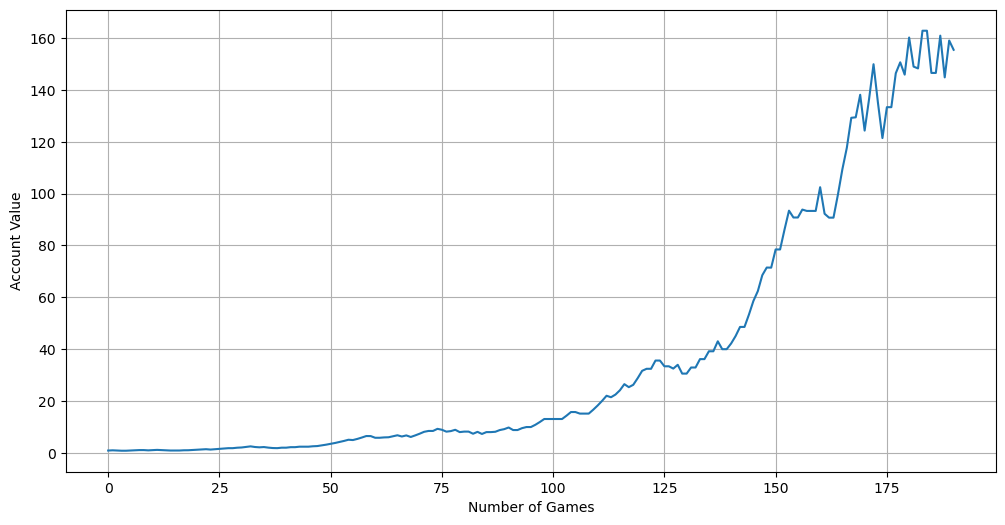

In [16]:
# best_params = study.best_trial.params
best_params = {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}
best_params = {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.010392255577263067, 'dropout': 0.3018270504618998, 'lr': 0.0020927261150450226, 'n_epochs': 100}
best_params = {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0074379232974536025, 'dropout': 0.3012002579065517, 'lr': 0.002814549768232188, 'n_epochs': 50}
best_params = {'batch_size': 3000, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.04546638880567819, 'dropout': 0.37992621523991776, 'lr': 0.008323138912104327, 'n_epochs': 58}
layer_shape = [best_params['first_layer_size']]
for i in range(1, best_params['num_layers']):
    layer_shape.append(best_params['first_layer_size']//(2*i))

# Set random state to have consistent results (42 is arbitrary)
set_all_seeds()
model = TabularModelUpdated(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=layer_shape,
    p=best_params['dropout'],     # Dropout
    # criterion=nfl_utils.map_losses(best_params['criterion']),
    optimizer_class=torch.optim.Adam,
    lr= best_params['lr'],   # Learning rate 
    confidence_threshold=best_params['confidence_threshold'],
    batch_size=best_params['batch_size']
)


pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

perf_y_col_tensor = torch.FloatTensor(perf_y_col).to(device)

# Run once on each split, track average loss, stop if > max patience
for _ in range(0, (best_params['n_epochs'] - 10)):
    running_loss = 0.0
    # ----- Train -----
    pipeline.fit(conts_train, y_train)

    # ----- Eval -----
    loss = pipeline.score(perf_conts, perf_y_col_tensor)
    # print(f"loss: {loss}")

# pipeline.fit(conts_train, y_train)
probas = pipeline.predict(perf_conts)
probas = probas[:, 0]
confidence_threshold = best_params['confidence_threshold']
# print(probas)

performance_tensor = nfl_custom_criterion(probas, perf_y_col_tensor, 0.5, 0.1, True)

y_axis = torch.cumprod(performance_tensor, dim=0).numpy()
x_axis = np.arange(len(y_axis))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, y_axis)
# plt.title(f'Backtest Results\nWin Rate: {win_rate:.2%} | ROI: {roi:.2%} | Max DD: {max_drawdown:.2%}')
plt.xlabel('Number of Games')
plt.ylabel('Account Value')
plt.grid(True)
plt.show()
# print(performance_tensor)

In [17]:
performance_tensor = nfl_custom_criterion(probas, perf_y_col_tensor, 0.5, 0.1, True)

print(performance_tensor)

tensor([0.9000, 1.0981, 0.9000, 0.9353, 1.0000, 1.0981, 1.0981, 1.0758, 1.0000,
        0.9000, 1.0825, 1.0981, 0.9332, 0.9358, 0.9000, 1.0000, 1.0064, 1.0981,
        1.0179, 1.0981, 1.0981, 1.0639, 1.0840, 0.9000, 1.0981, 1.0981, 1.0934,
        1.0782, 1.0000, 1.0981, 1.0448, 1.0981, 1.0981, 0.9000, 0.9470, 1.0500,
        0.9000, 0.9225, 0.9779, 1.0981, 1.0000, 1.0977, 1.0014, 1.0832, 1.0000,
        1.0000, 1.0670, 1.0319, 1.0981, 1.0981, 1.0981, 1.0981, 1.0981, 1.0981,
        1.0981, 0.9777, 1.0883, 1.0981, 1.0981, 0.9969, 0.9000, 1.0000, 1.0237,
        1.0094, 1.0665, 1.0569, 0.9310, 1.0656, 0.9110, 1.0981, 1.0981, 1.0981,
        1.0412, 1.0000, 1.0963, 0.9614, 0.9186, 1.0252, 1.0604, 0.9000, 1.0237,
        1.0000, 0.9000, 1.0981, 0.9000, 1.0981, 1.0000, 1.0157, 1.0807, 1.0408,
        1.0692, 0.9000, 1.0000, 1.0823, 1.0454, 1.0000, 1.0870, 1.0981, 1.0981,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0981, 1.0981, 1.0000, 0.9616, 1.0000,
        1.0000, 1.0981, 1.0981, 1.0981, 

[0.9        1.0981293  0.9        0.93526787 1.         1.0981293
 1.0981293  1.0758438  1.         0.9        1.082486   1.0981293
 0.93317986 0.935849   0.9        1.         1.0064094  1.0981293
 1.0178558  1.0981293  1.0981293  1.0638872  1.0840467  0.9
 1.0981293  1.0981293  1.0934234  1.0782238  1.         1.0981293
 1.0447731  1.0981293  1.0981293  0.9        0.94697005 1.0499836
 0.9        0.9225351  0.9778983  1.0981293  1.         1.0977113
 1.0013821  1.0832494  1.         1.         1.0670011  1.0319269
 1.0981293  1.0981293  1.0981293  1.0981293  1.0981293  1.0981293
 1.0981293  0.97766703 1.0883164  1.0981293  1.0981293  0.99690104
 0.9        1.         1.0237193  1.0093768  1.0665088  1.0569421
 0.93097544 1.0655825  0.91097295 1.0981293  1.0981293  1.0981293
 1.0412054  1.         1.0962868  0.9613913  0.91858816 1.0252378
 1.0604135  0.9        1.0237387  1.         0.9        1.0981293
 0.9        1.0981293  1.         1.0156734  1.0806606  1.0408075
 1.0691772  0.9

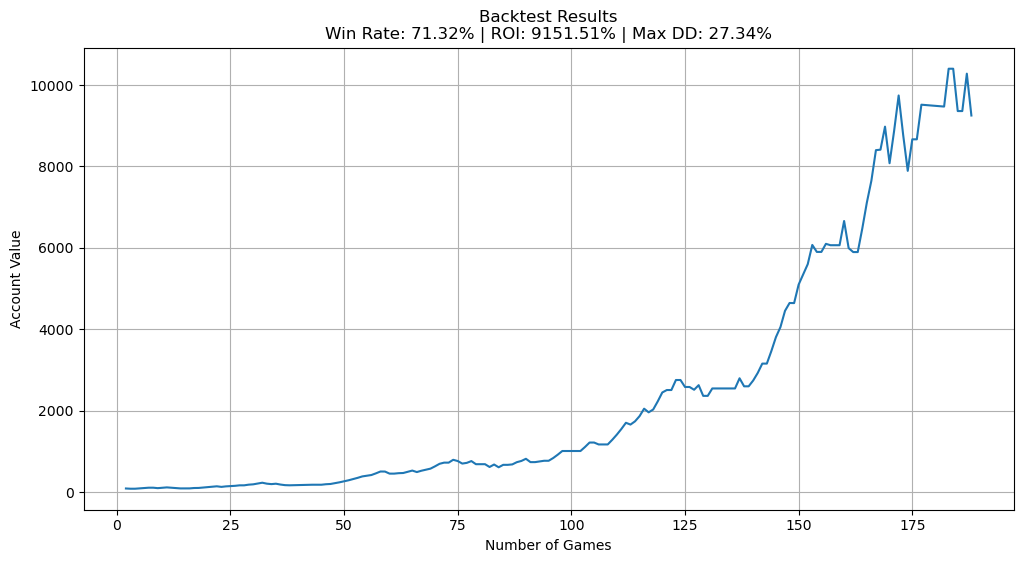

{'final_value': 9251.513574122291,
 'roi': 91.5151357412229,
 'win_rate': 0.7132352941176471,
 'max_drawdown': 0.27342514848014315,
 'total_bets': 170}

In [18]:
performance_tensor = nfl_custom_criterion(probas, perf_y_col_tensor, 0.5, 0.1, True).numpy()
print(performance_tensor)
print(perf_date_col)
nfl_utils.backtest_model_custom_loss(performance_tensor, perf_date_col, initial_capital=100, show_plot=True)

['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.36 acct_val: 1000.00 usable cash: 900.00 won: False
2024-10-14: w_odds:1.43 acct_val: 900.00 usable cash: 810.00 won: False
2024-10-14: w_odds:1.58 acct_val: 810.00 usable cash: 729.00 won: False
2024-10-14: w_odds:1.46 acct_val: 729.00 usable cash: 656.10 won: False
2024-10-14: w_odds:1.30 acct_val: 656.10 usable cash: 590.49 won: False
2024-10-14: w_odds:1.25 acct_val: 590.49 usable cash: 531.44 won: False
2024-10-14: w_odds:1.33 acct_val: 531.44 usable cash: 478.30 won: False
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.83 acct_val: 478.30 usable cash: 430.47 won: False
['2024-10-20' 'PHI' 'NYG']
2024-10-20: w_odds:1.58 acct_val: 430.47 usable cash: 387.42 won: False
['2024-10-21' 'BAL' 'TAM']
2024-10-21: w_odds:1.58 acct_val: 387.42 usable cash: 348.68 won: False
2024-10-21: w_odds:1.94 acct_val: 348.68 usable cash: 313.81 won: False
2024-10-21: w_odds:1.12 acct_val: 313.81 usable cash: 282.43 won: False
2024-10-21: w_odds:1.58 acc

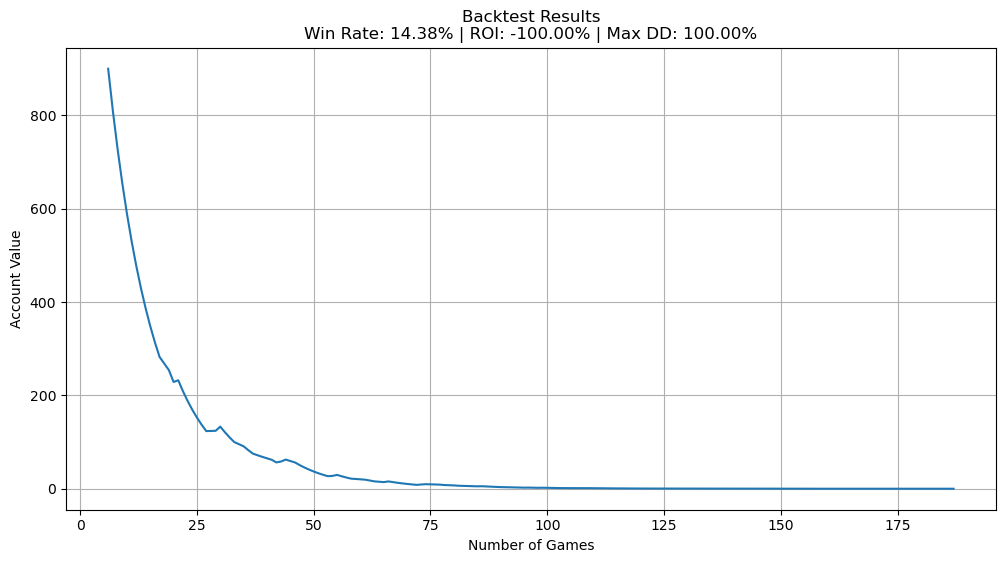

{'final_value': 0.005379082512624256,
 'roi': -0.9999946209174874,
 'win_rate': 0.1437908496732026,
 'max_drawdown': 0.9999946209174874,
 'total_bets': 153}

In [95]:
nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.

[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.



Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}.




['2024-02-11' 'SFO' 'KAN']
2024-02-11: w_odds:2.89 acct_val: 1000.00 usable cash: 900.00 won: False
['2024-10-10' 'SFO' 'SEA']
2024-10-10: w_odds:2.03 acct_val: 900.00 usable cash: 810.00 won: False
['2024-10-13' 'JAX' 'CHI']
2024-10-13: w_odds:1.46 acct_val: 810.00 usable cash: 729.00 won: False
['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.99 acct_val: 729.00 usable cash: 656.10 won: False
2024-10-14: w_odds:1.36 acct_val: 656.10 usable cash: 590.49 won: False
2024-10-14: w_odds:1.43 acct_val: 590.49 usable cash: 531.44 won: True
2024-10-14: w_odds:1.58 acct_val: 615.80 usable cash: 469.86 won: True
2024-10-14: w_odds:1.46 acct_val: 651.67 usable cash: 404.69 won: False
2024-10-14: w_odds:1.30 acct_val: 586.50 usable cash: 346.04 won: True
2024-10-14: w_odds:1.25 acct_val: 604.00 usable cash: 285.64 won: False
2024-10-14: w_odds:1.33 acct_val: 543.60 usable cash: 231.29 won: True
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.83 acct_val: 561.51 usable cash: 505.36 won: False
['20

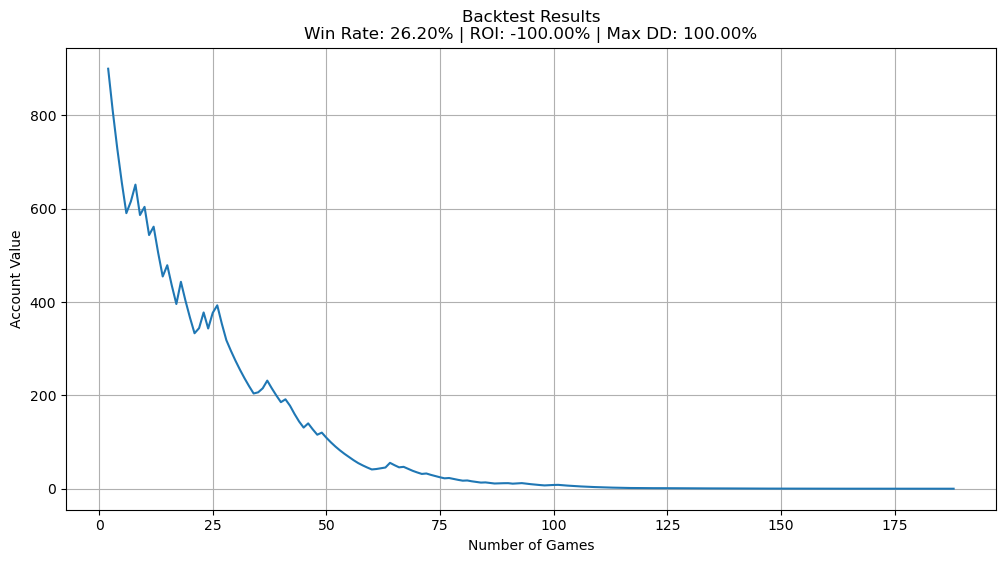

{'final_value': 0.015363152411150683,
 'roi': -0.9999846368475889,
 'win_rate': 0.2620320855614973,
 'max_drawdown': 0.9999846368475889,
 'total_bets': 187}

In [18]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.05, confidence_threshold=best_params['confidence_threshold'], show_plot=True)


In [19]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

0.25654450261780104


# Using XGBoost

In [20]:
conts_train.shape

(5264, 49)

In [ ]:
# Fit the model
param_grid = {
    'learning_rate': [ 0.008, 0.01, 0.03],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}
aparam_grid = {
    'learning_rate': [0.005, 0.01, 0.05],        # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3],                         # Simplified to 3 values, covering shallow to deep
    'n_estimators': [300, 350, 400],             # Removed extremes, these are most common sweet spots
    'subsample': [0.5, 0.6, 0.7],                # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.5, 0.6, 0.7],         # Same as above
    'min_child_weight': [3, 4],                  # Removed 5 as it might be too restrictive
}

# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBRegressor(objective='reg:squarederror')

# Create a custom scorer using the F1 score
# f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
# grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
print(grid_search.best_params_)

In [ ]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_,
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 31.4%
    # {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 30.9%
    # {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.6}
)
model = XGBRegressor(
    objective='reg:squarederror', 
    # **grid_search.best_params_,
    # 67.3 w/ kelly adjustments 0.2, 0.01
    # {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 350, 'subsample': 0.6}
    # 67.2, dd 28.68 kelly 0.25, 0.014
    # **{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 350, 'subsample': 0.5}
    
   # **{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.5}
    **{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

In [ ]:
# perf_conts.shape
perf_y_col.shape
perf_y_col[0]

In [ ]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

In [ ]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save XGBoost model

In [ ]:
model.save_model('xgboost_model.bin')